#  IN3050/IN4050 Mandatory Assignment 1: Traveling Salesman Problem
# Vetle Olavesen Feb.2024

## Introduction
In this exercise, you will attempt to solve an instance of the traveling salesman problem (TSP) using different
methods. The goal is to become familiar with evolutionary algorithms and to appreciate their effectiveness on a
difficult search problem. You have to use Python to solve the assignment. You must write
your program from scratch (but you may use non-EA-related libraries).


|  &nbsp;   | Barcelona | Belgrade |  Berlin | Brussels | Bucharest | Budapest |
|:---------:|:---------:|:--------:|:-------:|:--------:|:---------:|:--------:|
| Barcelona |     0     |  1528.13 | 1497.61 |  1062.89 |  1968.42  |  1498.79 |
|  Belgrade |  1528.13  |     0    |  999.25 |  1372.59 |   447.34  |  316.41  |
|   Berlin  |  1497.61  |  999.25  |    0    |  651.62  |  1293.40  |  1293.40 |
|  Brussels |  1062.89  |  1372.59 |  651.62 |     0    |  1769.69  |  1131.52 |
| Bucharest |  1968.42  |  447.34  | 1293.40 |  1769.69 |     0     |  639.77  |
|  Budapest |  1498.79  |  316.41  | 1293.40 |  1131.52 |   639.77  |     0    |


<center>Figure 1: First 6 cities from csv file.</center>


## Problem
The traveling salesman, wishing to disturb the residents of the major cities in some region of the world in
the shortest time possible, is faced with the problem of finding the shortest tour among the cities. A tour
is a path that starts in one city, visits all of the other cities, and then returns to the starting point. The
relevant pieces of information, then, are the cities and the distances between them. In this instance of the
TSP, a number of European cities are to be visited. Their relative distances are given in the data file, *european_cities.csv*, found in the zip file with the mandatory assignment.

(You will use permutations to represent tours in your programs. The **itertools** module in Python provides
a permutations function that returns successive permutations, this is useful for exhaustive search)

## Helper code for visualizing solutions

Here follows some helper code that you can use to visualize the plans you generate. These visualizations can **help you check if you are making sensible tours or not**. The optimization algoritms below should hopefully find relatively nice looking tours, but perhaps with a few visible inefficiencies.

In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(57)
#Map of Europe
europe_map = plt.imread('map.png')

#Lists of city coordinates
city_coords = {
    "Barcelona": [2.154007, 41.390205], "Belgrade": [20.46, 44.79], "Berlin": [13.40, 52.52], 
    "Brussels": [4.35, 50.85], "Bucharest": [26.10, 44.44], "Budapest": [19.04, 47.50],
    "Copenhagen": [12.57, 55.68], "Dublin": [-6.27, 53.35], "Hamburg": [9.99, 53.55], 
    "Istanbul": [28.98, 41.02], "Kyiv": [30.52, 50.45], "London": [-0.12, 51.51], 
    "Madrid": [-3.70, 40.42], "Milan": [9.19, 45.46], "Moscow": [37.62, 55.75],
    "Munich": [11.58, 48.14], "Paris": [2.35, 48.86], "Prague": [14.42, 50.07],
    "Rome": [12.50, 41.90], "Saint Petersburg": [30.31, 59.94], "Sofia": [23.32, 42.70],
    "Stockholm": [18.06, 60.33], "Vienna": [16.36, 48.21], "Warsaw": [21.02, 52.24]}


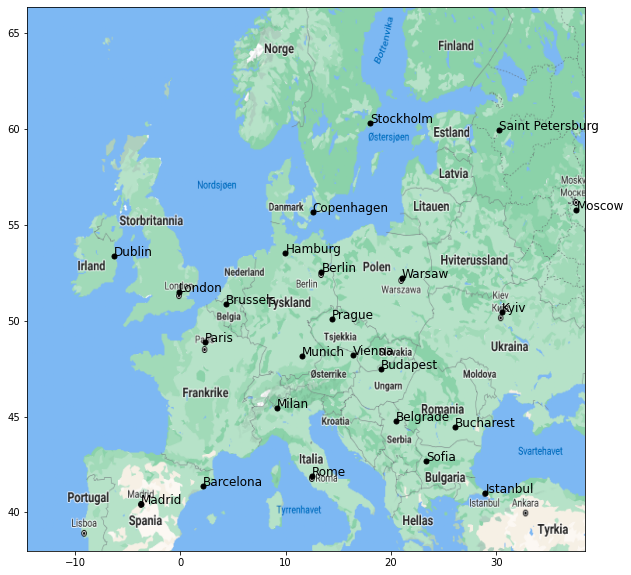

In [8]:
#Helper code for plotting plans
#First, visualizing the cities.
import csv
with open("european_cities.csv", "r") as f:
    data = list(csv.reader(f, delimiter=';'))
    cities = data[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

# Map (long, lat) to (x, y) for plotting
for city, location in city_coords.items():
    x, y = (location[0], location[1])
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, city, fontsize=12)


In [9]:
#A method you can use to plot your plan on the map.
def plot_plan(city_order):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

    # Map (long, lat) to (x, y) for plotting
    for index in range(len(city_order) - 1):
        current_city_coords = city_coords[city_order[index]]
        next_city_coords = city_coords[city_order[index+1]]
        x, y = current_city_coords[0], current_city_coords[1]
        #Plotting a line to the next city
        next_x, next_y = next_city_coords[0], next_city_coords[1]
        plt.plot([x, next_x], [y, next_y])

        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, index, fontsize=12)
    #Finally, plotting from last to first city
    first_city_coords = city_coords[city_order[0]]
    first_x, first_y = first_city_coords[0], first_city_coords[1]
    plt.plot([next_x, first_x], [next_y, first_y])
    #Plotting a marker and index for the final city
    plt.plot(next_x, next_y, 'ok', markersize=5)
    plt.text(next_x, next_y, index+1, fontsize=12)
    plt.show()


['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest', 'Copenhagen', 'Dublin', 'Hamburg', 'Istanbul', 'Kyiv', 'London', 'Madrid', 'Milan', 'Moscow', 'Munich', 'Paris', 'Prague', 'Rome', 'Saint Petersburg', 'Sofia', 'Stockholm', 'Vienna', 'Warsaw']


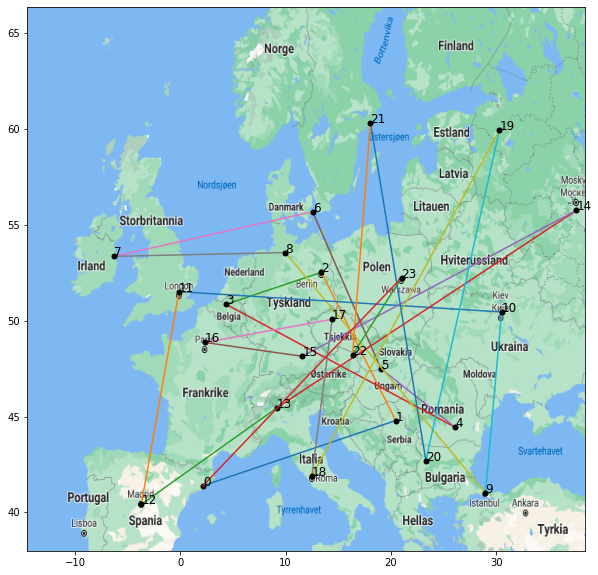

In [10]:
#Example usage of the plotting-method.
plan = list(city_coords.keys()) # Gives us the cities in alphabetic order
print(plan)
plot_plan(plan)

## Exhaustive Search
First, try to solve the problem by inspecting every possible tour. Start by writing a program to find the shortest
tour among a subset of the cities (say, **6** of them). Measure the amount of time your program takes. Incrementally
add more cities and observe how the time increases. Plot the shortest tours you found using the plot_plan method above, for 6 and 10 cities.

**Note:** To get distances between cities, use the dictionary `data` created by reading the file `european_cities.csv`. *Do not* calculate distances based on the coordinates. The actual distances do not only depend on the differences in the coordinates, but also of the curvature of the earth. The distances available in `data` are corrected for this, and contain the actual true distances.

In [11]:
# Implement the algorithm here
from itertools import permutations

distances = data[1::]
test_cities = cities[:10]

"""
Function for calculating the total distance of the tour
"""
def distance(tour):
    dst = 0
    for i in range(0,len(tour) - 1):#Iterate through all cities in each permutation and add the distance from city to city.
        
        dst += float(distances[data[0].index(tour[i])][data[0].index(tour[i+1])])
        
    dst += float(distances[data[0].index(tour[-1])][data[0].index(tour[0])]) #Add distance from last to first city
    
    return dst

"""
Function for finding the shortest tour through exhaustive search.
Takes a list of cities to find the tour through.
"""

def exhaustive_search(cities):
    perms = list(permutations(cities)) # Finds all permutations subset of cities.
    global_max = [None,None]
    
    for perm in perms: # Iterate through all permutations
        local_max = [perm,0]
        local_max[1] = distance(perm)
        
        if (global_max[0] == None):
            global_max[0] = local_max[0]
            global_max[1] = local_max[1]
            
        elif (local_max[1] < global_max[1]):
            global_max[0] = local_max[0]
            global_max[1] = local_max[1]
    
    return global_max

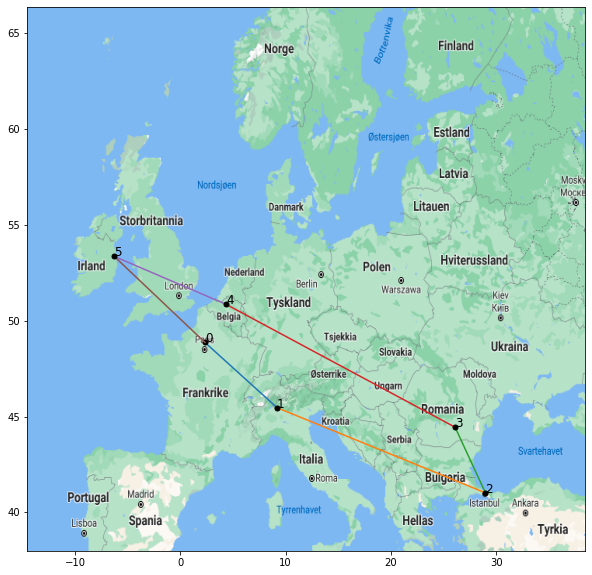

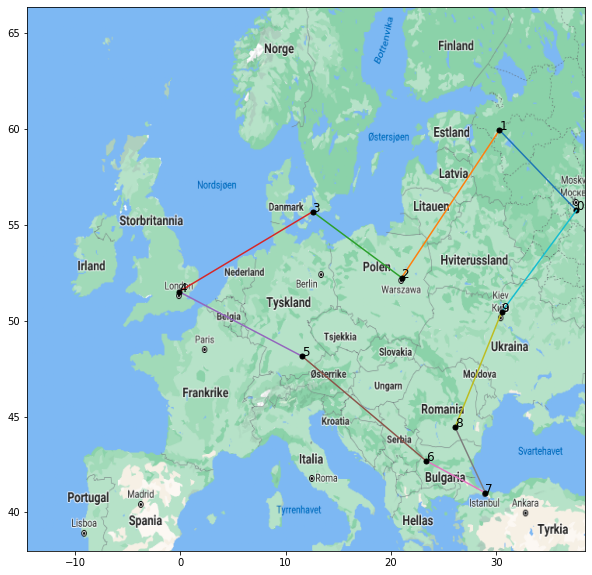

In [7]:
# Pick a random subset of cities, and call exhaustive search on the subset.
test_cities6 = np.random.choice(cities, 6, replace=False)
test_cities10 = np.random.choice(cities, 10, replace=False)

answ6 = exhaustive_search(test_cities6)
answ10 = exhaustive_search(test_cities10)
plot_plan(answ6[0])
plot_plan(answ10[0])

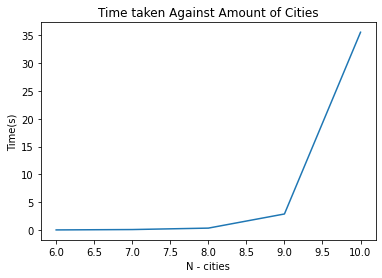

In [8]:
# Take time for for 6 upto 10 cities and plot the time against amount of cities to see how the time for
# the algorithm increases.

time_exh = []
n_cities = [6,7,8,9,10]


for i in n_cities:
    test_cities = np.random.choice(cities, i, replace=False)
    start = time.time()
    answ = exhaustive_search(test_cities)
    end = time.time()
    time_exh.append((end - start))

plt.xlabel("N - cities")
plt.ylabel("Time(s)")
plt.title("Time taken Against Amount of Cities")
plt.plot(n_cities, time_exh)

What is the shortest tour (i.e., the actual sequence of cities, and its length) among the first 10 cities (that is,
the cities starting with B,C,D,H and I)? How long did your program take to find it? Calculate an approximation of how long it would take to perform exhaustive search on all 24 cities?

In [11]:
# Answer

start = time.time()
print(f"Shortest tour among the first 10 citiest: {exhaustive_search(test_cities)} \n")
end = time.time()
print(f"Time exhaustive search used to find shortest tour: {end - start}")


Shortest tour among the first 10 citiest: [('Copenhagen', 'Hamburg', 'Brussels', 'Dublin', 'Barcelona', 'Belgrade', 'Istanbul', 'Bucharest', 'Budapest', 'Berlin'), 7486.309999999999] 

Time exhaustive search used to find shortest tour: 23.49899458885193


### Answer to Questions

#### What is the shortest tour (i.e., the actual sequence of cities, and its length) among the first 10 cities (that is, the cities starting with B,C,D,H and I)?

- The shortest tour among the first ten cities are: ('Bucharest', 'Belgrade', 'Budapest', 'Berlin', 'Copenhagen', 'Hamburg', 'Brussels', 'Dublin', 'Barcelona', 'Istanbul').

#### How long did your program take to find it?

- Time exhaustive search used to find shortest tour: 15.03 [seconds]

#### Calculate an approximation of how long it would take to perform exhaustive search on all 24 cities?

- For 10 cities, the we get 3,628,800 permutations, that took ca 15 seconds, so $\frac{1}{241920}$ seconds per permutation. For 24 cities, we get $6.204484e+23$ permutations. Which in a rough approximation, will give us a time of: $\frac{1}{241920} * 6.204484e+23 = 2.6e+18$ s. Which is: $8.2e+10$ years.

## Hill Climbing
Then, write a simple hill climber to solve the TSP. How well does the hill climber perform, compared to the result from the exhaustive search for the first **10 cities**? Since you are dealing with a stochastic algorithm, you
should run the algorithm several times to measure its performance. Report the length of the tour of the best,
worst and mean of 20 runs (with random starting tours), as well as the standard deviation of the runs, both with the **10 first cities**, and with all **24 cities**. Plot one of the the plans from the 20 runs for both 10 cities and 24 cities (you can use plot_plan). 

Time for Hill Climb: First ten cities: 0.0


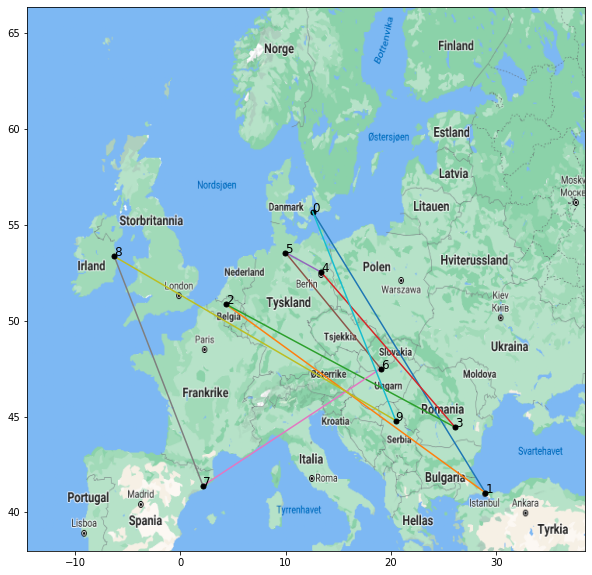

First 10 cities: Mean: 10241.428499999998 Worst: 13562.179999999998 Best: 7824.950000000001 

All Cities: Mean: 33118.979999999996 Worst: 33118.98 Best: 33118.98 



In [15]:
import random

def hill_climb(cities):
    evals = 0
    shf_cit = cities
    random.shuffle(shf_cit) # Shuffle the cities
    best = [shf_cit, distance(shf_cit)]
    
    
    while (evals < 50):
        evals += 1
        
        # Finding neighbour solution
        new_sol = best[0]
        idx = range(len(new_sol))
        i1,i2 = random.sample(idx,2)
        new_sol[i1], new_sol[i2] = new_sol[i2], new_sol[i1]
        new_distance = distance(new_sol)
        
        if (new_distance < best[1]):
            best = [new_sol, new_distance]
            evals = 0 #If we find a better solution, algorithm runs a bit longer
            
    return best

start = time.time()
answ = hill_climb(test_cities)
end = time.time()

print(f"Time for Hill Climb: First ten cities: {(end - start)}")

plot_plan(answ[0])

# Running hill climb for 20 runs to find mean, best and worst solutions, for 10 and 24 cities.
sol_10 = np.zeros(20) # List to store answers for 10 first cities
sol_24 = np.zeros(20) # List to store answers for all cities

for i in range(20):
    sol_10[i] = hill_climb(test_cities)[1]
    sol_24[i] = hill_climb(cities)[1]

print(f"First 10 cities: Mean: {np.mean(sol_10)} Worst: {np.max(sol_10)} Best: {np.min(sol_10)} \n")
print(f"All Cities: Mean: {np.mean(sol_24)} Worst: {np.max(sol_24)} Best: {np.min(sol_24)} \n")

### Answer to Questions

#### How well does the hill climber perform, compared to the result from the exhaustive search for the first 10 cities?

- In terms of time taken, hill climb is faster than exhaustive search, atleast for larger amount of cities, but in terms of answer correctness, hill climb often comes with a worse solution than exhaustive search does.

####

####

## Genetic Algorithm
Next, write a genetic algorithm (GA) to solve the problem. Choose mutation and crossover operators that are appropriate for the problem (see chapter 4.5 of the Eiben and Smith textbook). Choose three different values for the population size. Define and tune other parameters yourself and make assumptions as necessary (and report them, of course).

For all three variants: As with the hill climber, report best, worst, mean and standard deviation of tour length out of 20 runs of the algorithm (of the best individual of last generation). Also, find and plot the average fitness of the best fit individual in each generation (average across runs), and include a figure with all three curves in the same plot in the report. This means that the x-axis should be the generations over time and the y-axis should be the average (over the 20-runs) fitness of the best gene in that generation. Conclude which is best in terms of tour length and number of generations of evolution time.

Finally, plot an example optimized tour (the best of the final generation) for the three different population sizes, using the plot_plan method.

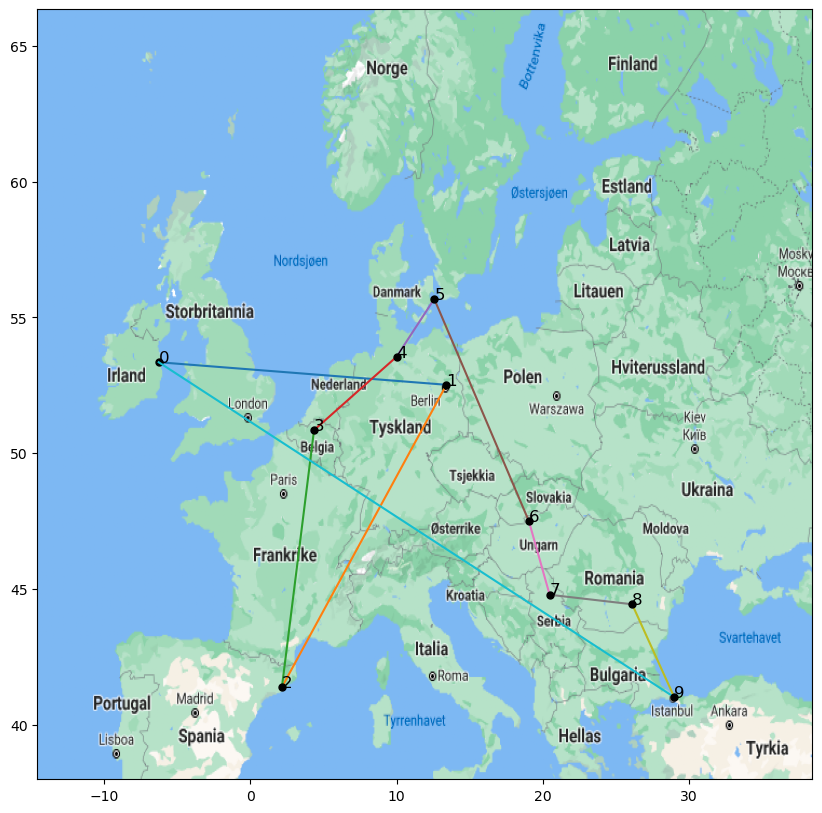

Time taken 10 cities: 0.1953105926513672s. 24 Cities: 0.5289833545684814s


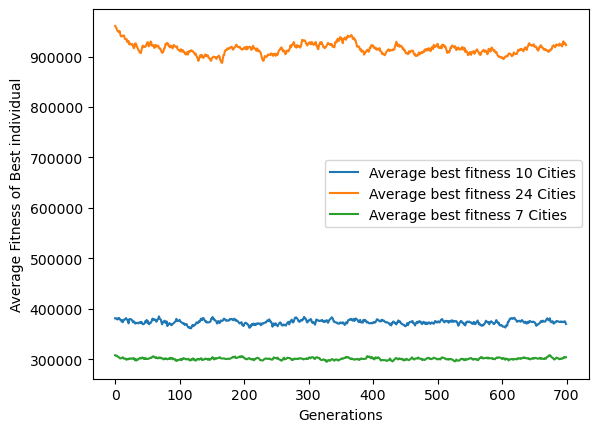

Out of 20 runs of 3 sizes of population these are the results: 

Best 10: 8363.05 Best 24: 26005.64 Best 7: 8218.24 

Worst 10: 11536.34 Worst 24: 32260.260000000002 Worst 7: 10383.199999999999 

Mean 10: 10096.157500000001 Mean 24: 28956.161 Mean 7: 9244.143999999998 

Standard dev 10: 872.8217280170963 Std 24: 1832.0486120703788 Std 7: 511.75780457556255 



In [92]:
import statistics
# Implement the algorithm here
def pmx_pair(P1,P2):
    cross_c1_1 = random.randint(0,len(P1)-1)
    cross_c1_2 = random.randint(cross_c1_1, len(P1)-1)
    cross_c2_1 = random.randint(0,len(P1)-1)
    cross_c2_2 = random.randint(cross_c2_1, len(P1)-1)
    c1 = [None]*len(P1)
    c2 = [None]*len(P1)
    
    # Copy segment of P1 into Child 1 and 2
    c1[cross_c1_1:cross_c1_2+1] = P1[cross_c1_1:cross_c1_2+1]
    c2[cross_c2_1:cross_c2_2+1] = P1[cross_c2_1:cross_c2_2+1]
    
    # Find a place for the elements in P2 that are within the cross segment, but isnt placed in the child yet.
    for i in range(cross_c1_1, cross_c1_2 + 1):           # Loop over cross segment
        if (P2[i] not in c1):                             # If element in P2 within the cross segment isnt copied to child
            j = P2.index(P1[i])                            
            
            while (c1[j] != None):                         
                j = P2.index(P1[j])
            c1[j] = P2[i]
            
    # In the still-empty places within the child, we copy the corresponding value from P2
    for i in range(len(c1)): 
        if (c1[i] == None):
            c1[i] = P2[i]
    
    
    # Same procedures, but for child 2.
    for i in range(cross_c2_1, cross_c2_2 + 1):
        if (P2[i] not in c2):
            j = P2.index(P1[i])
            
            while (c2[j] != None):
                j = P2.index(P1[j])
            c2[j] = P2[i]
    
    for i in range(len(c2)):
        if (c2[i] == None):
            c2[i] = P2[i]
            
    
    return c1, c2

def GA(pop, generations):
    popu = list(pop)
    
    fittest_gen = []
        
    for g in range(generations):
        for i in range(len(popu)):
            popu[i] = list(popu[i])
        # Calculate fitness of each solution
        weights = []
        for i in range(len(popu)):
            weights.append(distance(popu[i]))
            
        total_weight = sum(weights)
        
        for i in range(len(weights)):
            weights[i] = (total_weight-weights[i])

        # Parent selection, select an even number of parents
        k = int(len(popu)/2)
        if (k % 2 != 0):
            k += 1
        if i == 0:
            parents = popu[:k]
        else:
            parents = random.choices(popu, weights = weights, k = k)
        
        # Mutating and crossover
        # I choose swap mutation, so we will get 'some' change in mutation, but not too much.
        count = 0
        while (count < len(parents)):
            c1, c2 = pmx_pair(parents[count], parents[count + 1])
            popu.append(c1)
            popu.append(c2)
            count += 2
        
        #Swap mutation
        for p in popu:
            if (random.random() <= .25): #Choise of mutation rate, is chosen on a whim, could optimize this more.
                i1 = random.randint(0, len(p)-1)
                i2 = random.randint(0, len(p)-1)
                p[i1], p[i2] = p[i2], p[i1] 
                
        # Select the survivors for the next generation
        weights = []
        for i in range(len(popu)):
            weights.append(distance(popu[i]))
        
        total_weight = sum(weights)
        
        for i in range(len(weights)):
            weights[i] = (total_weight-weights[i]) # Fitness
            
        fittest_gen.append(max(weights))
        popu = random.choices(popu, weights = weights, k = 20)
    
    # Calculating weights again to find best solution after GA
    weights = []
    for i in range(len(popu)):
        weights.append(distance(popu[i]))
            
    total_weight = sum(weights)
        
    for i in range(len(weights)):
        weights[i] = (total_weight-weights[i])
        
    # Choose best as 'max' of weights because of how weights are defined, max weight = min distance
    best = popu[weights.index(max(weights))]
    
    return best, distance(best), fittest_gen
            
pop_10 = [cities[:10]]*20
pop_24 = [cities]*20
pop_7 = [cities[11:19]]*20

# Uses GA to find shortest route of first 10 cities. And takes the time
start = time.time()
best_10, d_best_10, fittest_gen_10 = GA(pop_10, 700)
end = time.time()

time_10 = (end-start)

start = time.time()
best_24, d_best_24, fittest_gen_24 = GA(pop_24, 700)
end = time.time()

time_24 = (end-start)

plot_plan(best_10)
print(f"Time taken 10 cities: {time_10}s. 24 Cities: {time_24}s")

generations = [i for i in range(700)] # For plot
fittest_all_10 = []
fittest_all_24 = []
fittest_all_7 = []

# Run the GA 20 times to find mean, best, etc.
pop_10_best = []
pop_24_best = []
pop_7_best = []
for i in range(20):
    best_10, d_best_10, fittest_gen_10 = GA(pop_10, 700)
    best_24, d_best_24, fittest_gen_24 = GA(pop_24, 700)
    best_7, d_best_7, fittest_gen_7 = GA(pop_7, 700)
    
    #Save the best individual of the run for each city list.
    pop_10_best.append(d_best_10)
    pop_24_best.append(d_best_24)
    pop_7_best.append(d_best_7)
    fittest_all_10.append(fittest_gen_10)
    fittest_all_24.append(fittest_gen_24)
    fittest_all_7.append(fittest_gen_7)

average_fit_10 = []
average_fit_24 = []    
average_fit_7 = []    
for i in range(len(fittest_all_10[0])):
    average_fit_10.append(np.mean([fittest_all_10[k][i] for k in range(20)]))
    average_fit_24.append(np.mean([fittest_all_24[k][i] for k in range(20)]))
    average_fit_7.append(np.mean([fittest_all_7[k][i] for k in range(20)]))

plt.plot(generations, average_fit_10, label = "Average best fitness 10 Cities")
plt.plot(generations, average_fit_24, label = "Average best fitness 24 Cities")
plt.plot(generations, average_fit_7, label = "Average best fitness 7 Cities")
plt.xlabel("Generations")
plt.ylabel("Average Fitness of Best individual")
plt.legend()
plt.show()
    
print("Out of 20 runs of 3 sizes of population these are the results: \n")
print(f"Best 10: {min(pop_10_best)} Best 24: {min(pop_24_best)} Best 7: {min(pop_7_best)} \n")
print(f"Worst 10: {max(pop_10_best)} Worst 24: {max(pop_24_best)} Worst 7: {max(pop_7_best)} \n")
print(f"Mean 10: {np.mean(pop_10_best)} Mean 24: {np.mean(pop_24_best)} Mean 7: {np.mean(pop_7_best)} \n")
print(f"Standard dev 10: {np.std(pop_10_best)} Std 24: {np.std(pop_24_best)} Std 7: {np.std(pop_7_best)} \n")

Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close? 

For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search? 

How many tours were inspected by your GA as compared to by the exhaustive search?

### Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close?

- No, the GA did not find the best solution, but it was close, and it probably would if i optimized som parameters.

### For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search? 

- Time taken 10 cities: 0.18848729133605957s. 24 Cities: 0.5677394866943359s, so the GA is much faster than the exhaustive search.

### How many tours were inspected by your GA as compared to by the exhaustive search?

- My hill climb algorithm didnt work for 24 cities because of the way i implemented it, by using permutations. So i cant compare this properly. And i dont have time to fix it.